In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/feature domain/Delta_frequency.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

In [ ]:
# %%capture
# !pip install wandb

In [ ]:
# import wandb

In [ ]:
# !wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# CNN-LSTM

In [6]:
%%capture
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_callback = ModelCheckpoint(
                f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN_LSTM/best_model_{run_name}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN_LSTM/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Evaluate client model
            y_pred = (client_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 27s 262ms/step - loss: 0.6931 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 2s 53ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5248
Epoch 3/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 40ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5636
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.6930 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5248
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 34ms/step - loss: 0.6929 - accuracy: 0.5073 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 8/100
29/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 76ms/step - loss: 0.6931 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 2/100
28/28 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5257 - val_loss: 0.6931 - val_accuracy: 0.5090
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6931 - accuracy: 0.5289 - val_loss: 0.6931 - val_accuracy: 0.5090
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5241 - val_loss: 0.6931 - val_accuracy: 0.5068
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.6929 - accuracy: 0.5337 - val_loss: 0.6931 - val_accuracy: 0.5124
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5328 - val_loss: 0.6931 - val_accuracy: 0.5068
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6927 - accuracy: 0.5388 - val_loss: 0.6931 - val_accuracy: 0.5068
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 10s 92ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5165
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6931 - accuracy: 0.5307 - val_loss: 0.6931 - val_accuracy: 0.5165
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5393 - val_loss: 0.6931 - val_accuracy: 0.5165
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 0.6929 - accuracy: 0.5429 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 0.6928 - accuracy: 0.5401 - val_loss: 0.6931 - val_accuracy: 0.5124
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 0.6926 - accuracy: 0.5388 - val_loss: 0.6931 - val_accuracy: 0.5176
Epoch 7/100
31/31 [==============================] - 1s 39ms/step - loss: 0.6922 - accuracy: 0.5421 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 8/100
31/31

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 10s 51ms/step - loss: 0.6667 - accuracy: 0.5884 - val_loss: 0.6905 - val_accuracy: 0.5269
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.6579 - accuracy: 0.5991 - val_loss: 0.6900 - val_accuracy: 0.5269
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6552 - accuracy: 0.5959 - val_loss: 0.6899 - val_accuracy: 0.5334
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.6516 - accuracy: 0.6051 - val_loss: 0.6898 - val_accuracy: 0.5312
Epoch 5/100
29/29 [==============================] - 0s 13ms/step - loss: 0.6506 - accuracy: 0.6072 - val_loss: 0.6893 - val_accuracy: 0.5334
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.6485 - accuracy: 0.6040 - val_loss: 0.6884 - val_accuracy: 0.5614
Epoch 7/100
29/29 [==============================] - 1s 32ms/step - loss: 0.6461 - accuracy: 0.6172 - val_loss: 0.6872 - val_accuracy: 0.5679
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 62ms/step - loss: 0.6609 - accuracy: 0.5829 - val_loss: 0.6913 - val_accuracy: 0.5102
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.6512 - accuracy: 0.6055 - val_loss: 0.6910 - val_accuracy: 0.5124
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.6510 - accuracy: 0.6106 - val_loss: 0.6912 - val_accuracy: 0.5090
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 0.6506 - accuracy: 0.6081 - val_loss: 0.6894 - val_accuracy: 0.5351
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6490 - accuracy: 0.6112 - val_loss: 0.6891 - val_accuracy: 0.5305
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6467 - accuracy: 0.6160 - val_loss: 0.6891 - val_accuracy: 0.5260
Epoch 7/100
28/28 [==============================] - 1s 22ms/step - loss: 0.6443 - accuracy: 0.6101 - val_loss: 0.6876 - val_accuracy: 0.5430
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 10s 75ms/step - loss: 0.6641 - accuracy: 0.5941 - val_loss: 0.6914 - val_accuracy: 0.5217
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 0.6535 - accuracy: 0.5990 - val_loss: 0.6915 - val_accuracy: 0.5176
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.6526 - accuracy: 0.6047 - val_loss: 0.6913 - val_accuracy: 0.5217
Epoch 4/100
31/31 [==============================] - 1s 48ms/step - loss: 0.6518 - accuracy: 0.6101 - val_loss: 0.6910 - val_accuracy: 0.5269
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 0.6510 - accuracy: 0.6067 - val_loss: 0.6910 - val_accuracy: 0.5258
Epoch 6/100
31/31 [==============================] - 1s 45ms/step - loss: 0.6504 - accuracy: 0.6142 - val_loss: 0.6901 - val_accuracy: 0.5362
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 0.6465 - accuracy: 0.6147 - val_loss: 0.6899 - val_accuracy: 0.5362
Epoch 8/100
31/31

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 64ms/step - loss: 0.5832 - accuracy: 0.6727 - val_loss: 0.6857 - val_accuracy: 0.5905
Epoch 2/100
29/29 [==============================] - 0s 16ms/step - loss: 0.5740 - accuracy: 0.6791 - val_loss: 0.6851 - val_accuracy: 0.5528
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5715 - accuracy: 0.6800 - val_loss: 0.6851 - val_accuracy: 0.5700
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.5719 - accuracy: 0.6875 - val_loss: 0.6834 - val_accuracy: 0.5690
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5689 - accuracy: 0.6765 - val_loss: 0.6818 - val_accuracy: 0.5938
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5660 - accuracy: 0.6848 - val_loss: 0.6805 - val_accuracy: 0.5776
Epoch 7/100
29/29 [==============================] - 1s 26ms/step - loss: 0.5668 - accuracy: 0.6910 - val_loss: 0.6788 - val_accuracy: 0.6024
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 54ms/step - loss: 0.5877 - accuracy: 0.6743 - val_loss: 0.6840 - val_accuracy: 0.5645
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.5736 - accuracy: 0.6797 - val_loss: 0.6851 - val_accuracy: 0.5238
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.5636 - accuracy: 0.6899 - val_loss: 0.6807 - val_accuracy: 0.5554
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.5693 - accuracy: 0.6811 - val_loss: 0.6797 - val_accuracy: 0.5758
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.5662 - accuracy: 0.6766 - val_loss: 0.6786 - val_accuracy: 0.5486
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.5602 - accuracy: 0.6969 - val_loss: 0.6752 - val_accuracy: 0.5758
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.5682 - accuracy: 0.6919 - val_loss: 0.6739 - val_accuracy: 0.5566
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 67ms/step - loss: 0.5900 - accuracy: 0.6638 - val_loss: 0.6857 - val_accuracy: 0.5548
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.5860 - accuracy: 0.6708 - val_loss: 0.6872 - val_accuracy: 0.5279
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.5838 - accuracy: 0.6700 - val_loss: 0.6865 - val_accuracy: 0.5289
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5754 - accuracy: 0.6783 - val_loss: 0.6829 - val_accuracy: 0.5558
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.5738 - accuracy: 0.6734 - val_loss: 0.6826 - val_accuracy: 0.5403
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.5761 - accuracy: 0.6791 - val_loss: 0.6801 - val_accuracy: 0.5764
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.5741 - accuracy: 0.6827 - val_loss: 0.6781 - val_accuracy: 0.5671
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 54ms/step - loss: 0.5023 - accuracy: 0.7325 - val_loss: 0.6829 - val_accuracy: 0.5356
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.4977 - accuracy: 0.7454 - val_loss: 0.6843 - val_accuracy: 0.5776
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.5041 - accuracy: 0.7268 - val_loss: 0.6875 - val_accuracy: 0.5054
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 0.4859 - accuracy: 0.7465 - val_loss: 0.6815 - val_accuracy: 0.5237
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 0.4849 - accuracy: 0.7460 - val_loss: 0.6777 - val_accuracy: 0.5345
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.4840 - accuracy: 0.7497 - val_loss: 0.6722 - val_accuracy: 0.6002
Epoch 7/100
29/29 [==============================] - 0s 13ms/step - loss: 0.4828 - accuracy: 0.7500 - val_loss: 0.6758 - val_accuracy: 0.5733
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 54ms/step - loss: 0.5091 - accuracy: 0.7377 - val_loss: 0.6731 - val_accuracy: 0.5758
Epoch 2/100
28/28 [==============================] - 1s 21ms/step - loss: 0.4992 - accuracy: 0.7436 - val_loss: 0.6732 - val_accuracy: 0.5837
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 0.4887 - accuracy: 0.7499 - val_loss: 0.6692 - val_accuracy: 0.5984
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.4849 - accuracy: 0.7510 - val_loss: 0.6668 - val_accuracy: 0.6176
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 0.4882 - accuracy: 0.7459 - val_loss: 0.6623 - val_accuracy: 0.5962
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.4847 - accuracy: 0.7490 - val_loss: 0.6608 - val_accuracy: 0.6075
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.4765 - accuracy: 0.7637 - val_loss: 0.6526 - val_accuracy: 0.6063
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 66ms/step - loss: 0.5328 - accuracy: 0.7225 - val_loss: 0.6782 - val_accuracy: 0.5940
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5131 - accuracy: 0.7359 - val_loss: 0.6783 - val_accuracy: 0.5320
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.5073 - accuracy: 0.7367 - val_loss: 0.6791 - val_accuracy: 0.5382
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5010 - accuracy: 0.7328 - val_loss: 0.6742 - val_accuracy: 0.5548
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 0.4989 - accuracy: 0.7323 - val_loss: 0.6714 - val_accuracy: 0.5857
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.5029 - accuracy: 0.7357 - val_loss: 0.6683 - val_accuracy: 0.5630
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.5011 - accuracy: 0.7411 - val_loss: 0.6672 - val_accuracy: 0.5517
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 68ms/step - loss: 0.4345 - accuracy: 0.7923 - val_loss: 0.7094 - val_accuracy: 0.5011
Epoch 2/100
29/29 [==============================] - 1s 25ms/step - loss: 0.4144 - accuracy: 0.7977 - val_loss: 0.6900 - val_accuracy: 0.5086
Epoch 3/100
29/29 [==============================] - 1s 29ms/step - loss: 0.4064 - accuracy: 0.7977 - val_loss: 0.6831 - val_accuracy: 0.5226
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3976 - accuracy: 0.8015 - val_loss: 0.7000 - val_accuracy: 0.5108
Epoch 5/100
29/29 [==============================] - 0s 13ms/step - loss: 0.3978 - accuracy: 0.7980 - val_loss: 0.6927 - val_accuracy: 0.5216
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.4037 - accuracy: 0.8050 - val_loss: 0.6740 - val_accuracy: 0.5528
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.4017 - accuracy: 0.8001 - val_loss: 0.6695 - val_accuracy: 0.5927
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 56ms/step - loss: 0.4379 - accuracy: 0.7861 - val_loss: 0.6692 - val_accuracy: 0.5441
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.4111 - accuracy: 0.8090 - val_loss: 0.6658 - val_accuracy: 0.5566
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.4054 - accuracy: 0.8081 - val_loss: 0.6714 - val_accuracy: 0.5430
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.4179 - accuracy: 0.8065 - val_loss: 0.6818 - val_accuracy: 0.5373
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.4101 - accuracy: 0.8065 - val_loss: 0.6532 - val_accuracy: 0.5860
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.4048 - accuracy: 0.8053 - val_loss: 0.6518 - val_accuracy: 0.5860
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 0.3976 - accuracy: 0.8132 - val_loss: 0.6460 - val_accuracy: 0.5882
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 65ms/step - loss: 0.4493 - accuracy: 0.7788 - val_loss: 0.6742 - val_accuracy: 0.5279
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 0.4368 - accuracy: 0.7739 - val_loss: 0.6649 - val_accuracy: 0.6064
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4249 - accuracy: 0.7863 - val_loss: 0.6744 - val_accuracy: 0.5269
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.4274 - accuracy: 0.7917 - val_loss: 0.6785 - val_accuracy: 0.5217
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.4190 - accuracy: 0.7964 - val_loss: 0.6571 - val_accuracy: 0.6167
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 0.4250 - accuracy: 0.7801 - val_loss: 0.6529 - val_accuracy: 0.6167
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.4240 - accuracy: 0.7910 - val_loss: 0.6581 - val_accuracy: 0.5661
Epoch 8/100
31/31 

In [ ]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.549,0.556,0.487,0.520,0.487,0.611,0.099
1,1,0.566,0.615,0.356,0.451,0.356,0.777,0.133
2,2,0.557,0.570,0.466,0.513,0.466,0.649,0.114
3,0,0.528,0.525,0.586,0.554,0.586,0.469,0.055
4,1,0.546,0.552,0.484,0.516,0.484,0.607,0.092
5,2,0.598,0.586,0.673,0.626,0.673,0.524,0.197
6,0,0.560,0.550,0.663,0.601,0.663,0.457,0.121
7,1,0.579,0.578,0.583,0.581,0.583,0.575,0.158
8,2,0.614,0.584,0.799,0.675,0.799,0.430,0.229
9,0,0.593,0.590,0.608,0.599,0.608,0.578,0.186


In [ ]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/CNN_LSTM/Delta_CNN_LSTM.csv', index = False)

# Draw Plot

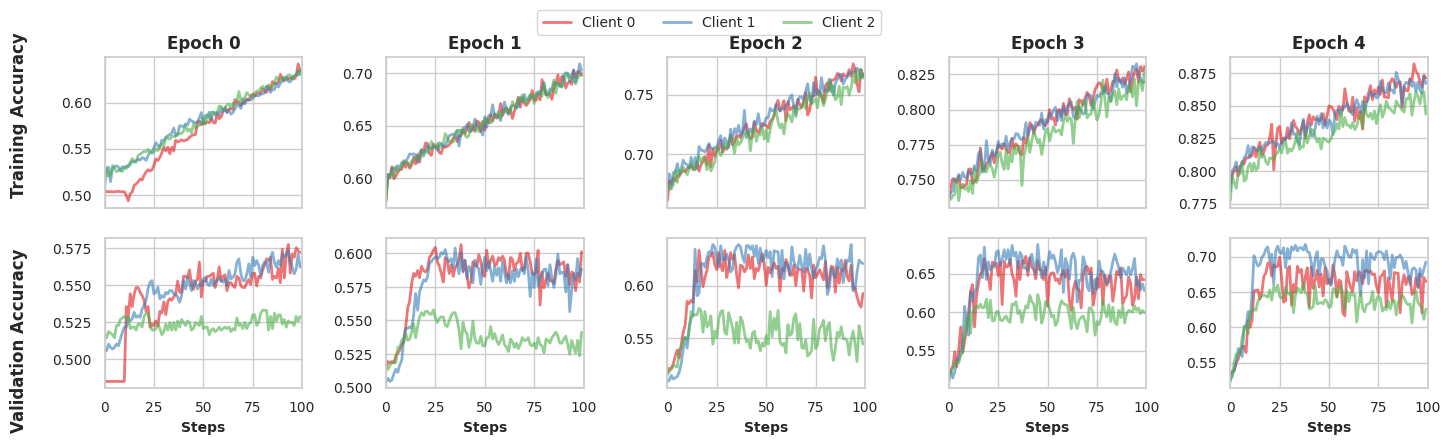

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy
def plot_accuracy(all_metrics_df, unique_epochs, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create subplots for each epoch
    fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Iterate through each epoch and plot the training and validation accuracy
    for i, epoch in enumerate(unique_epochs):
        epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
        for j, client in enumerate(epoch_df['client_number'].unique()):
            client_df = epoch_df[epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
            if not client_df.empty:
                line, = axes[0, i].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
                axes[1, i].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

                if i == 0:
                    lines.append(line)
                    labels.append(f'Client {client}')

        axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
        axes[0, i].grid(True)
        axes[1, i].grid(True)
        axes[0, i].tick_params(axis='both', which='major', labelsize=10)
        axes[1, i].tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

    # Add row labels
    fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Get unique epochs from the dataframe
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Plot the accuracy
plot_accuracy(all_metrics_df, unique_epochs, output_dir)


# CNN

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN/training_log_{run_name}.csv', append=True, separator=';')


            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)


            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [12]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 13s 104ms/step - loss: 1.7713 - accuracy: 0.5019 - val_loss: 1.7664 - val_accuracy: 0.4752
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 1.7596 - accuracy: 0.5038 - val_loss: 1.7556 - val_accuracy: 0.4698
Epoch 3/100
29/29 [==============================] - 0s 16ms/step - loss: 1.7483 - accuracy: 0.5038 - val_loss: 1.7450 - val_accuracy: 0.5399
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 1.7374 - accuracy: 0.5151 - val_loss: 1.7345 - val_accuracy: 0.5668
Epoch 5/100
29/29 [==============================] - 0s 9ms/step - loss: 1.7264 - accuracy: 0.5145 - val_loss: 1.7240 - val_accuracy: 0.5582
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 1.7157 - accuracy: 0.5251 - val_loss: 1.7137 - val_accuracy: 0.5506
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 1.7050 - accuracy: 0.5307 - val_loss: 1.7034 - val_accuracy: 0.5463
Epoch 8/100
29/29 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 6s 138ms/step - loss: 1.7715 - accuracy: 0.5048 - val_loss: 1.7667 - val_accuracy: 0.5283
Epoch 2/100
28/28 [==============================] - 1s 24ms/step - loss: 1.7599 - accuracy: 0.4983 - val_loss: 1.7564 - val_accuracy: 0.5419
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 1.7488 - accuracy: 0.5153 - val_loss: 1.7461 - val_accuracy: 0.5294
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 1.7379 - accuracy: 0.5190 - val_loss: 1.7359 - val_accuracy: 0.5238
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 1.7274 - accuracy: 0.5184 - val_loss: 1.7257 - val_accuracy: 0.5260
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 1.7168 - accuracy: 0.5357 - val_loss: 1.7157 - val_accuracy: 0.5238
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss: 1.7062 - accuracy: 0.5354 - val_loss: 1.7058 - val_accuracy: 0.5283
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 6s 124ms/step - loss: 1.7704 - accuracy: 0.5044 - val_loss: 1.7658 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 1.7573 - accuracy: 0.5145 - val_loss: 1.7543 - val_accuracy: 0.5145
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 1.7452 - accuracy: 0.5129 - val_loss: 1.7429 - val_accuracy: 0.5258
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 1.7331 - accuracy: 0.5326 - val_loss: 1.7317 - val_accuracy: 0.5310
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 1.7214 - accuracy: 0.5253 - val_loss: 1.7206 - val_accuracy: 0.5289
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 1.7099 - accuracy: 0.5323 - val_loss: 1.7097 - val_accuracy: 0.5320
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 1.6986 - accuracy: 0.5419 - val_loss: 1.6989 - val_accuracy: 0.5320
Epoch 8/100
31/31

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 99ms/step - loss: 1.0731 - accuracy: 0.6285 - val_loss: 1.1365 - val_accuracy: 0.5162
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 1.0638 - accuracy: 0.6393 - val_loss: 1.1325 - val_accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 1.0596 - accuracy: 0.6401 - val_loss: 1.1277 - val_accuracy: 0.5194
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0553 - accuracy: 0.6398 - val_loss: 1.1231 - val_accuracy: 0.5259
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0476 - accuracy: 0.6460 - val_loss: 1.1197 - val_accuracy: 0.5356
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0433 - accuracy: 0.6519 - val_loss: 1.1151 - val_accuracy: 0.5399
Epoch 7/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0372 - accuracy: 0.6622 - val_loss: 1.1108 - val_accuracy: 0.5496
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 11ms/step - loss: 1.0615 - accuracy: 0.6406 - val_loss: 1.1348 - val_accuracy: 0.5057
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 1.0580 - accuracy: 0.6466 - val_loss: 1.1331 - val_accuracy: 0.5057
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0527 - accuracy: 0.6477 - val_loss: 1.1253 - val_accuracy: 0.5102
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0462 - accuracy: 0.6508 - val_loss: 1.1207 - val_accuracy: 0.5147
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0418 - accuracy: 0.6582 - val_loss: 1.1174 - val_accuracy: 0.5170
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 1.0367 - accuracy: 0.6520 - val_loss: 1.1146 - val_accuracy: 0.5181
Epoch 8/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0322 - accuracy: 0.6534 - val_loss: 1.1076 - val_accuracy: 0.5317
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 16ms/step - loss: 1.0661 - accuracy: 0.6323 - val_loss: 1.1326 - val_accuracy: 0.5165
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 1.0624 - accuracy: 0.6357 - val_loss: 1.1284 - val_accuracy: 0.5165
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 1.0542 - accuracy: 0.6447 - val_loss: 1.1239 - val_accuracy: 0.5207
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 1.0493 - accuracy: 0.6442 - val_loss: 1.1199 - val_accuracy: 0.5269
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 1.0461 - accuracy: 0.6442 - val_loss: 1.1159 - val_accuracy: 0.5269
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 1.0398 - accuracy: 0.6424 - val_loss: 1.1116 - val_accuracy: 0.5320
Epoch 8/100
31/31 [==============================] - 0s 16ms/step - loss: 1.0352 - accuracy: 0.6455 - val_loss: 1.1086 - val_accuracy: 0.5362
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 16ms/step - loss: 0.7853 - accuracy: 0.7139 - val_loss: 0.9513 - val_accuracy: 0.5776
Epoch 3/100
29/29 [==============================] - 0s 10ms/step - loss: 0.7738 - accuracy: 0.7223 - val_loss: 0.9503 - val_accuracy: 0.5474
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7697 - accuracy: 0.7320 - val_loss: 0.9478 - val_accuracy: 0.5226
Epoch 5/100
29/29 [==============================] - 0s 11ms/step - loss: 0.7666 - accuracy: 0.7228 - val_loss: 0.9428 - val_accuracy: 0.5776
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7617 - accuracy: 0.7425 - val_loss: 0.9435 - val_accuracy: 0.5927
Epoch 7/100
29/29 [==============================] - 0s 11ms/step - loss: 0.7598 - accuracy: 0.7249 - val_loss: 0.9385 - val_accuracy: 0.5431
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7566 - accuracy: 0.7279 - val_loss: 0.9331 - val_accuracy: 0.5894
Epoch 9/100
29/29 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 11ms/step - loss: 0.7707 - accuracy: 0.7289 - val_loss: 0.9565 - val_accuracy: 0.5136
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 0.7687 - accuracy: 0.7289 - val_loss: 0.9485 - val_accuracy: 0.5362
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.7658 - accuracy: 0.7394 - val_loss: 0.9456 - val_accuracy: 0.5611
Epoch 5/100
28/28 [==============================] - 1s 40ms/step - loss: 0.7604 - accuracy: 0.7346 - val_loss: 0.9422 - val_accuracy: 0.5622
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.7552 - accuracy: 0.7456 - val_loss: 0.9433 - val_accuracy: 0.5407
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.7553 - accuracy: 0.7357 - val_loss: 0.9361 - val_accuracy: 0.5543
Epoch 8/100
28/28 [==============================] - 0s 13ms/step - loss: 0.7528 - accuracy: 0.7411 - val_loss: 0.9342 - val_accuracy: 0.5532
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 11ms/step - loss: 0.7891 - accuracy: 0.7116 - val_loss: 0.9556 - val_accuracy: 0.5186
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7820 - accuracy: 0.7245 - val_loss: 0.9478 - val_accuracy: 0.5579
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7750 - accuracy: 0.7271 - val_loss: 0.9448 - val_accuracy: 0.5661
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.7745 - accuracy: 0.7207 - val_loss: 0.9435 - val_accuracy: 0.5640
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 0.7677 - accuracy: 0.7276 - val_loss: 0.9400 - val_accuracy: 0.5527
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.7650 - accuracy: 0.7359 - val_loss: 0.9378 - val_accuracy: 0.5548
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7631 - accuracy: 0.7346 - val_loss: 0.9342 - val_accuracy: 0.5682
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 21ms/step - loss: 0.6313 - accuracy: 0.7982 - val_loss: 0.9065 - val_accuracy: 0.5226
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6269 - accuracy: 0.7971 - val_loss: 0.9054 - val_accuracy: 0.5593
Epoch 4/100
29/29 [==============================] - 0s 13ms/step - loss: 0.6176 - accuracy: 0.8031 - val_loss: 0.9109 - val_accuracy: 0.5140
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 0.6177 - accuracy: 0.8093 - val_loss: 0.8959 - val_accuracy: 0.5442
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 0.6177 - accuracy: 0.8044 - val_loss: 0.9023 - val_accuracy: 0.5269
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.6231 - accuracy: 0.8041 - val_loss: 0.9338 - val_accuracy: 0.5065
Epoch 8/100
29/29 [==============================] - 0s 12ms/step - loss: 0.6159 - accuracy: 0.8055 - val_loss: 0.9270 - val_accuracy: 0.5172
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 18ms/step - loss: 0.6317 - accuracy: 0.7937 - val_loss: 0.9043 - val_accuracy: 0.5441
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 0.6325 - accuracy: 0.7957 - val_loss: 0.9036 - val_accuracy: 0.5271
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.6269 - accuracy: 0.8076 - val_loss: 0.9034 - val_accuracy: 0.5283
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 0.6188 - accuracy: 0.8217 - val_loss: 0.9016 - val_accuracy: 0.5260
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.6128 - accuracy: 0.8124 - val_loss: 0.9008 - val_accuracy: 0.5283
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6150 - accuracy: 0.8166 - val_loss: 0.8996 - val_accuracy: 0.5328
Epoch 8/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6066 - accuracy: 0.8209 - val_loss: 0.9068 - val_accuracy: 0.5362
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 15ms/step - loss: 0.6612 - accuracy: 0.7713 - val_loss: 0.9033 - val_accuracy: 0.5372
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6460 - accuracy: 0.7987 - val_loss: 0.9025 - val_accuracy: 0.5661
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.6441 - accuracy: 0.7894 - val_loss: 0.8986 - val_accuracy: 0.5682
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.6437 - accuracy: 0.7817 - val_loss: 0.8997 - val_accuracy: 0.5434
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 0.6447 - accuracy: 0.7891 - val_loss: 0.9134 - val_accuracy: 0.5196
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 0.6292 - accuracy: 0.8013 - val_loss: 0.9038 - val_accuracy: 0.5238
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 0.6354 - accuracy: 0.7990 - val_loss: 0.8987 - val_accuracy: 0.5289
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 17ms/step - loss: 0.5302 - accuracy: 0.8618 - val_loss: 0.8936 - val_accuracy: 0.5108
Epoch 3/100
29/29 [==============================] - 0s 16ms/step - loss: 0.5354 - accuracy: 0.8483 - val_loss: 0.8889 - val_accuracy: 0.5399
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 0.5278 - accuracy: 0.8553 - val_loss: 0.9091 - val_accuracy: 0.5075
Epoch 5/100
29/29 [==============================] - 0s 11ms/step - loss: 0.5285 - accuracy: 0.8578 - val_loss: 0.9585 - val_accuracy: 0.5043
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 0.5180 - accuracy: 0.8607 - val_loss: 0.9216 - val_accuracy: 0.5140
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5209 - accuracy: 0.8607 - val_loss: 0.8937 - val_accuracy: 0.5323
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5297 - accuracy: 0.8537 - val_loss: 0.9170 - val_accuracy: 0.5226
Epoch 9/100
29/29 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 11ms/step - loss: 0.5546 - accuracy: 0.8401 - val_loss: 0.8925 - val_accuracy: 0.5238
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5415 - accuracy: 0.8427 - val_loss: 0.9002 - val_accuracy: 0.5260
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5349 - accuracy: 0.8580 - val_loss: 0.9046 - val_accuracy: 0.5260
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5256 - accuracy: 0.8602 - val_loss: 0.9000 - val_accuracy: 0.5215
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5164 - accuracy: 0.8568 - val_loss: 0.9101 - val_accuracy: 0.5385
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5200 - accuracy: 0.8580 - val_loss: 0.8986 - val_accuracy: 0.5317
Epoch 8/100
28/28 [==============================] - 0s 12ms/step - loss: 0.5172 - accuracy: 0.8690 - val_loss: 0.9172 - val_accuracy: 0.5464
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 21ms/step - loss: 0.5543 - accuracy: 0.8406 - val_loss: 0.8881 - val_accuracy: 0.5713
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.5520 - accuracy: 0.8318 - val_loss: 0.8937 - val_accuracy: 0.5207
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.5605 - accuracy: 0.8411 - val_loss: 0.9113 - val_accuracy: 0.5196
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.5658 - accuracy: 0.8248 - val_loss: 0.8873 - val_accuracy: 0.5289
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 0.5541 - accuracy: 0.8382 - val_loss: 0.9179 - val_accuracy: 0.5176
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 0.5581 - accuracy: 0.8326 - val_loss: 0.8864 - val_accuracy: 0.5568
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 0.5572 - accuracy: 0.8336 - val_loss: 0.8823 - val_accuracy: 0.5723
Epoch 9/100
31/31 

In [13]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.556,0.567,0.474,0.516,0.474,0.638,0.112
1,1,0.547,0.558,0.448,0.497,0.448,0.645,0.093
2,2,0.535,0.550,0.386,0.453,0.386,0.685,0.070
3,0,0.592,0.637,0.429,0.513,0.429,0.755,0.184
4,1,0.562,0.546,0.733,0.626,0.733,0.391,0.124
5,2,0.622,0.669,0.486,0.563,0.486,0.759,0.245
6,0,0.627,0.699,0.447,0.545,0.447,0.807,0.255
7,1,0.595,0.591,0.620,0.605,0.620,0.571,0.191
8,2,0.650,0.713,0.500,0.588,0.500,0.799,0.299
9,0,0.638,0.642,0.625,0.633,0.625,0.652,0.276


In [14]:
metrics_df_CNN.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/CNN/Delta_time_CNN.csv', index = False)

# Gru


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model_gru(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning_gru(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model_gru(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model_gru(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN_GRU/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Delta/CNN_GRU/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [16]:
global_model_gru, metrics_df_gru = federated_learning_gru(Theta_data)

Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 11ms/step - loss: 1.4224 - accuracy: 0.5040 - val_loss: 1.4195 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 11ms/step - loss: 1.4161 - accuracy: 0.5038 - val_loss: 1.4133 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 11ms/step - loss: 1.4098 - accuracy: 0.5038 - val_loss: 1.4072 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 1.4037 - accuracy: 0.5038 - val_loss: 1.4012 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 1.3975 - accuracy: 0.5038 - val_loss: 1.3951 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 1.3914 - accuracy: 0.5038 - val_loss: 1.3891 - val_accuracy: 0.5065
Epoch 8/100
29/29 [==============================] - 1s 23ms/step - loss: 1.3854 - accuracy: 0.5038 - val_loss: 1.3832 - val_accuracy: 0.5442
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 14ms/step - loss: 1.4226 - accuracy: 0.5023 - val_loss: 1.4199 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 1.4165 - accuracy: 0.5034 - val_loss: 1.4140 - val_accuracy: 0.5385
Epoch 4/100
28/28 [==============================] - 0s 12ms/step - loss: 1.4104 - accuracy: 0.4986 - val_loss: 1.4081 - val_accuracy: 0.5351
Epoch 5/100
28/28 [==============================] - 0s 12ms/step - loss: 1.4044 - accuracy: 0.5000 - val_loss: 1.4022 - val_accuracy: 0.5294
Epoch 6/100
28/28 [==============================] - 0s 12ms/step - loss: 1.3984 - accuracy: 0.5127 - val_loss: 1.3964 - val_accuracy: 0.5249
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 1.3924 - accuracy: 0.5127 - val_loss: 1.3907 - val_accuracy: 0.5215
Epoch 8/100
28/28 [==============================] - 0s 14ms/step - loss: 1.3864 - accuracy: 0.5076 - val_loss: 1.3849 - val_accuracy: 0.5260
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 80ms/step - loss: 1.4285 - accuracy: 0.5036 - val_loss: 1.4253 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 32ms/step - loss: 1.4215 - accuracy: 0.5023 - val_loss: 1.4187 - val_accuracy: 0.5289
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 1.4146 - accuracy: 0.5044 - val_loss: 1.4121 - val_accuracy: 0.5289
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 1.4077 - accuracy: 0.5090 - val_loss: 1.4056 - val_accuracy: 0.5279
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 1.4010 - accuracy: 0.5137 - val_loss: 1.3992 - val_accuracy: 0.5300
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 1.3941 - accuracy: 0.5173 - val_loss: 1.3929 - val_accuracy: 0.5300
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 1.3874 - accuracy: 0.5196 - val_loss: 1.3866 - val_accuracy: 0.5279
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 13ms/step - loss: 0.9745 - accuracy: 0.6183 - val_loss: 1.0166 - val_accuracy: 0.5172
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 0.9704 - accuracy: 0.6145 - val_loss: 1.0135 - val_accuracy: 0.5194
Epoch 4/100
29/29 [==============================] - 1s 24ms/step - loss: 0.9671 - accuracy: 0.6078 - val_loss: 1.0098 - val_accuracy: 0.5205
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.9609 - accuracy: 0.6180 - val_loss: 1.0060 - val_accuracy: 0.5259
Epoch 6/100
29/29 [==============================] - 1s 26ms/step - loss: 0.9604 - accuracy: 0.6148 - val_loss: 1.0029 - val_accuracy: 0.5269
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.9550 - accuracy: 0.6169 - val_loss: 1.0004 - val_accuracy: 0.5291
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.9512 - accuracy: 0.6193 - val_loss: 0.9971 - val_accuracy: 0.5323
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 14ms/step - loss: 0.9723 - accuracy: 0.6157 - val_loss: 1.0183 - val_accuracy: 0.5057
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 0.9683 - accuracy: 0.6126 - val_loss: 1.0151 - val_accuracy: 0.5068
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.9614 - accuracy: 0.6092 - val_loss: 1.0123 - val_accuracy: 0.5079
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.9590 - accuracy: 0.6135 - val_loss: 1.0103 - val_accuracy: 0.5079
Epoch 6/100
28/28 [==============================] - 1s 25ms/step - loss: 0.9551 - accuracy: 0.6200 - val_loss: 1.0057 - val_accuracy: 0.5124
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 0.9497 - accuracy: 0.6200 - val_loss: 1.0022 - val_accuracy: 0.5192
Epoch 8/100
28/28 [==============================] - 1s 26ms/step - loss: 0.9465 - accuracy: 0.6225 - val_loss: 0.9989 - val_accuracy: 0.5260
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 21ms/step - loss: 0.9762 - accuracy: 0.6041 - val_loss: 1.0162 - val_accuracy: 0.5176
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.9712 - accuracy: 0.6044 - val_loss: 1.0139 - val_accuracy: 0.5155
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.9678 - accuracy: 0.6044 - val_loss: 1.0101 - val_accuracy: 0.5165
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.9594 - accuracy: 0.6181 - val_loss: 1.0074 - val_accuracy: 0.5176
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.9581 - accuracy: 0.6072 - val_loss: 1.0040 - val_accuracy: 0.5238
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 0.9514 - accuracy: 0.6158 - val_loss: 1.0011 - val_accuracy: 0.5238
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 0.9485 - accuracy: 0.6181 - val_loss: 0.9973 - val_accuracy: 0.5310
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 16ms/step - loss: 0.7297 - accuracy: 0.6894 - val_loss: 0.8717 - val_accuracy: 0.5194
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7211 - accuracy: 0.6853 - val_loss: 0.8642 - val_accuracy: 0.5269
Epoch 4/100
29/29 [==============================] - 0s 13ms/step - loss: 0.7098 - accuracy: 0.7034 - val_loss: 0.8617 - val_accuracy: 0.5302
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.7105 - accuracy: 0.7031 - val_loss: 0.8560 - val_accuracy: 0.5345
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.7066 - accuracy: 0.7050 - val_loss: 0.8522 - val_accuracy: 0.5420
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.7023 - accuracy: 0.7031 - val_loss: 0.8502 - val_accuracy: 0.5442
Epoch 8/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6992 - accuracy: 0.7080 - val_loss: 0.8460 - val_accuracy: 0.5550
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 13ms/step - loss: 0.7250 - accuracy: 0.6873 - val_loss: 0.8738 - val_accuracy: 0.5090
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7150 - accuracy: 0.7001 - val_loss: 0.8727 - val_accuracy: 0.5136
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.7189 - accuracy: 0.6930 - val_loss: 0.8691 - val_accuracy: 0.5147
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.7062 - accuracy: 0.7097 - val_loss: 0.8580 - val_accuracy: 0.5226
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7009 - accuracy: 0.7074 - val_loss: 0.8526 - val_accuracy: 0.5294
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7013 - accuracy: 0.7054 - val_loss: 0.8452 - val_accuracy: 0.5385
Epoch 8/100
28/28 [==============================] - 0s 12ms/step - loss: 0.6983 - accuracy: 0.7100 - val_loss: 0.8527 - val_accuracy: 0.5362
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 62ms/step - loss: 0.7389 - accuracy: 0.6817 - val_loss: 0.8813 - val_accuracy: 0.5165
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.7318 - accuracy: 0.6842 - val_loss: 0.8614 - val_accuracy: 0.5258
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 0.7237 - accuracy: 0.6902 - val_loss: 0.8630 - val_accuracy: 0.5289
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 0.7260 - accuracy: 0.6891 - val_loss: 0.8549 - val_accuracy: 0.5320
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.7148 - accuracy: 0.6902 - val_loss: 0.8548 - val_accuracy: 0.5310
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.7166 - accuracy: 0.6943 - val_loss: 0.8511 - val_accuracy: 0.5393
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.7165 - accuracy: 0.6946 - val_loss: 0.8484 - val_accuracy: 0.5320
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 13ms/step - loss: 0.5689 - accuracy: 0.7780 - val_loss: 0.8148 - val_accuracy: 0.5334
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.5753 - accuracy: 0.7664 - val_loss: 0.8186 - val_accuracy: 0.5345
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5629 - accuracy: 0.7729 - val_loss: 0.8159 - val_accuracy: 0.5409
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5610 - accuracy: 0.7777 - val_loss: 0.8104 - val_accuracy: 0.5453
Epoch 6/100
29/29 [==============================] - 0s 13ms/step - loss: 0.5594 - accuracy: 0.7745 - val_loss: 0.8150 - val_accuracy: 0.5453
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5559 - accuracy: 0.7748 - val_loss: 0.8102 - val_accuracy: 0.5485
Epoch 8/100
29/29 [==============================] - 1s 24ms/step - loss: 0.5604 - accuracy: 0.7772 - val_loss: 0.7841 - val_accuracy: 0.5894
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 68ms/step - loss: 0.5959 - accuracy: 0.7654 - val_loss: 0.8421 - val_accuracy: 0.5238
Epoch 2/100
28/28 [==============================] - 1s 30ms/step - loss: 0.5811 - accuracy: 0.7646 - val_loss: 0.8265 - val_accuracy: 0.5317
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.5778 - accuracy: 0.7742 - val_loss: 0.8199 - val_accuracy: 0.5317
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.5748 - accuracy: 0.7683 - val_loss: 0.8162 - val_accuracy: 0.5339
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.5654 - accuracy: 0.7779 - val_loss: 0.8196 - val_accuracy: 0.5373
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5709 - accuracy: 0.7765 - val_loss: 0.7975 - val_accuracy: 0.5486
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.5671 - accuracy: 0.7841 - val_loss: 0.8073 - val_accuracy: 0.5452
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 55ms/step - loss: 0.6015 - accuracy: 0.7463 - val_loss: 0.8174 - val_accuracy: 0.5341
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.5967 - accuracy: 0.7550 - val_loss: 0.8638 - val_accuracy: 0.5289
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 0.5856 - accuracy: 0.7566 - val_loss: 0.8072 - val_accuracy: 0.5393
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.5877 - accuracy: 0.7641 - val_loss: 0.8183 - val_accuracy: 0.5382
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5822 - accuracy: 0.7581 - val_loss: 0.7966 - val_accuracy: 0.5486
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 0.5804 - accuracy: 0.7623 - val_loss: 0.8038 - val_accuracy: 0.5455
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5790 - accuracy: 0.7589 - val_loss: 0.7872 - val_accuracy: 0.5651
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 71ms/step - loss: 0.5008 - accuracy: 0.8087 - val_loss: 0.8434 - val_accuracy: 0.5291
Epoch 2/100
29/29 [==============================] - 1s 30ms/step - loss: 0.4850 - accuracy: 0.8163 - val_loss: 0.8445 - val_accuracy: 0.5334
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.4713 - accuracy: 0.8233 - val_loss: 0.7864 - val_accuracy: 0.5647
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.4745 - accuracy: 0.8219 - val_loss: 0.8084 - val_accuracy: 0.5485
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.4662 - accuracy: 0.8244 - val_loss: 0.8060 - val_accuracy: 0.5506
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.4591 - accuracy: 0.8268 - val_loss: 0.7982 - val_accuracy: 0.5560
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.4648 - accuracy: 0.8179 - val_loss: 0.7882 - val_accuracy: 0.5776
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 54ms/step - loss: 0.5056 - accuracy: 0.8090 - val_loss: 0.8372 - val_accuracy: 0.5271
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.4919 - accuracy: 0.8186 - val_loss: 0.8667 - val_accuracy: 0.5226
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.4813 - accuracy: 0.8254 - val_loss: 0.8339 - val_accuracy: 0.5351
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 0.4808 - accuracy: 0.8209 - val_loss: 0.8079 - val_accuracy: 0.5385
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.4758 - accuracy: 0.8277 - val_loss: 0.8373 - val_accuracy: 0.5407
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 0.4674 - accuracy: 0.8277 - val_loss: 0.8109 - val_accuracy: 0.5464
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.4649 - accuracy: 0.8316 - val_loss: 0.7719 - val_accuracy: 0.5667
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 47ms/step - loss: 0.5185 - accuracy: 0.7961 - val_loss: 0.8245 - val_accuracy: 0.5362
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.5110 - accuracy: 0.7997 - val_loss: 0.8777 - val_accuracy: 0.5320
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.5007 - accuracy: 0.8101 - val_loss: 0.8301 - val_accuracy: 0.5362
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4904 - accuracy: 0.8142 - val_loss: 0.8175 - val_accuracy: 0.5413
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.4929 - accuracy: 0.8090 - val_loss: 0.7712 - val_accuracy: 0.5723
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.4781 - accuracy: 0.8178 - val_loss: 0.7758 - val_accuracy: 0.5630
Epoch 7/100
31/31 [==============================] - 1s 27ms/step - loss: 0.4804 - accuracy: 0.8209 - val_loss: 0.7638 - val_accuracy: 0.5899
Epoch 8/100
31/31 

In [17]:
metrics_df_gru

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.549414,0.577023,0.370184,0.451020,0.370184,0.728643,0.098827
1,1,0.552260,0.580786,0.375706,0.456261,0.375706,0.728814,0.104520
2,2,0.540161,0.547847,0.459839,0.500000,0.459839,0.620482,0.080321
3,0,0.564489,0.581741,0.458961,0.513109,0.458961,0.670017,0.128978
4,1,0.560028,0.596811,0.370056,0.456844,0.370056,0.750000,0.120056
5,2,0.592369,0.621693,0.471888,0.536530,0.471888,0.712851,0.184739
6,0,0.596315,0.632184,0.460637,0.532946,0.460637,0.731993,0.192630
7,1,0.600989,0.676543,0.387006,0.492363,0.387006,0.814972,0.201977
8,2,0.646586,0.707386,0.500000,0.585882,0.500000,0.793173,0.293173
9,0,0.624791,0.620746,0.641541,0.630972,0.641541,0.608040,0.249581


In [18]:
metrics_df_gru.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/GRU/Delta_frequency_gru.csv', index = False)